# High-performance Evolutionary Algorithms for Online Neuron Control (GECCO 2022)

Binxu Wang, Carlos R. Ponce

**Author of notebook**: Binxu Wang (binxu_wang@hms.harvard.edu)

**Github Repo**: https://github.com/Animadversio/ActMax-Optimizer-Dev

## Set up 

Set up dependency and import basics

In [1]:
!git clone https://github.com/maochengxu/ActMax-Optimizer-Dev.git
!pip install cma==3.0.3
!pip install nevergrad==0.4.2.post5
# !pip install pytorch_pretrained_biggan
%cd ActMax-Optimizer-Dev
%mkdir tmp

Cloning into 'ActMax-Optimizer-Dev'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 375 (delta 4), reused 5 (delta 2), pack-reused 300
Receiving objects: 100% (375/375), 998.41 KiB | 20.80 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
/home/paperspace/mlproj2/ActMax-Optimizer-Dev


In [2]:
!git pull

Already up to date.


In [2]:
import torch
import numpy as np
from matplotlib import animation
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [3]:
assert torch.cuda.is_available(), "Need a GPU runtime to run evolutions efficiently."

## Simple Evolution Experiment

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 2.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
synth img scores: mean 1.161 +- std 0.000
step 0  time: total 0.26s | GAN visualize 0.04s   CNN score 0.05s   optimizer step 0.17s
sigma: 1.94
synth img scores: mean -0.311 +- std 0.643
step 1  time: total 0.84s | GAN visualize 0.11s   CNN score 0.55s   optimizer step 0.18s
sigma: 1.88
synth img scores: mean -0.254 +- std 0.583
step 2  time: total 0.65s | GAN visualize 0.07s   CNN score 0.52s   optimizer step 0.07s
sigma: 1.84
synth img scores: mean 0.114 +- std 0.741
step 3  time: total 0.64s | GAN visualize 0.06s   CNN score 0.52s   optimizer step 0.07s
sigma: 1.80
synth img scores: mean 0.703 +- std 0.863
step 4  time: total 0.65s | GAN visualize 0.07s   CNN score 0.52s   optimizer step 0.07s
sigma: 1.77
synth img scores: mean 0.654 +- std 0.798
step 5  time: total 0.66s | GAN visualize 0.05s   CNN score 0.52s   optimizer step 0.08s
sigma

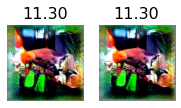

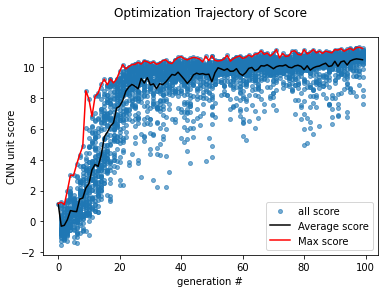

Last generation and Best code saved.


In [4]:
from core.insilico_exps import ExperimentEvolution
from core.Optimizers import CholeskyCMAES, ZOHA_Sphere_lr_euclid, Genetic, pycma_optimizer

tmpsavedir = "tmp" # Temporary save directory

# load optimizer
optim = CholeskyCMAES(4096, population_size=40, init_sigma=2.0, Aupdate_freq=10, init_code=np.zeros([1, 4096]))
# un-comment to use our new one! 
# optim = ZOHA_Sphere_lr_euclid(4096, population_size=40, select_size=20, lr=1.5, sphere_norm=300)
# optim.lr_schedule(n_gen=75, mode="exp", lim=(50, 7.33) ,)
explabel, model_unit = "vit_b_16_exp", ("vit_b_16", ".heads.Linearhead", 1)
# explabel, model_unit = "alexnet_fc8_1", ("alexnet", ".classifier.Linear6", 1)
Exp = ExperimentEvolution(model_unit, savedir=tmpsavedir, explabel=explabel, optimizer=optim)
# run evolutions
Exp.run()
Exp.visualize_best()
Exp.visualize_trajectory()
Exp.save_last_gen()

## Animate the course of evolution

In [5]:
from core.GAN_utils import upconvGAN
G = upconvGAN("fc6")
G.cuda().eval();

In [6]:
avg_codes = [Exp.codes_all[Exp.generations == geni, :].mean(axis=0) for geni in range(100)]
avg_codes = np.stack(avg_codes)
avg_activ = np.array([Exp.scores_all[Exp.generations == geni].mean(axis=0) for geni in range(100)])
print(avg_codes.shape)
print(avg_activ.shape)

(100, 4096)
(100,)


In [7]:
imgs_per_gen = G.visualize_batch_np(avg_codes)
imgs_per_gen_np = imgs_per_gen.permute([0,2,3,1]).numpy()
print(imgs_per_gen.shape)

torch.Size([100, 3, 256, 256])


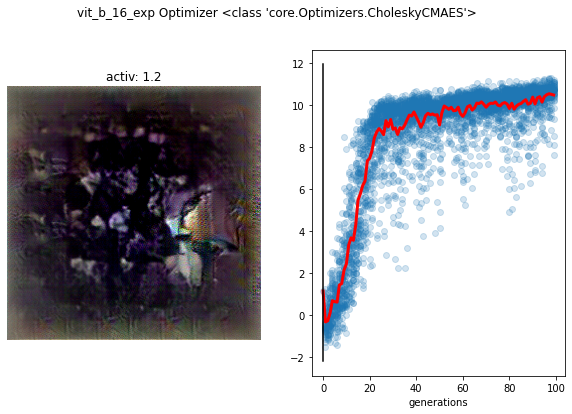

In [8]:
fig, axs = plt.subplots(1, 2, figsize=[10,6])
tit = axs[0].set_title(f"activ: {avg_activ[0]:.1f}")
ims = axs[0].imshow(imgs_per_gen_np[0])
axs[0].axis("Off")
axs[1].scatter(Exp.generations, Exp.scores_all, alpha=0.2)
axs[1].plot(range(100), avg_activ, c="red", lw=3)
axs[1].set_xlabel("generations")
fig.suptitle(f"{explabel} Optimizer {str(type(optim))}")
YLIM = axs[1].get_ylim()
lin1, = axs[1].plot([0,0], YLIM, color="k")
def drawframe_score(n):
    ims.set_data(imgs_per_gen_np[n])
    tit.set_text(f"activ: {avg_activ[n]:.1f}")
    lin1.set_data([n, n], YLIM)
    return (ims, tit, lin1) 

In [13]:
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe_score, frames=100, interval=100, blit=False, repeat=True)
anim.save('basic_animation.mp4', fps=30)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x432 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y basic_animation.mp4


In [14]:
#@title Make the Animation function `animate_evol_exp`, `animate_evol_images`
def animate_evol_exp(Exp: ExperimentEvolution):
    avg_codes = [Exp.codes_all[Exp.generations == geni, :].mean(axis=0) for geni in range(100)]
    avg_codes = np.stack(avg_codes)
    avg_activ = np.array([Exp.scores_all[Exp.generations == geni].mean(axis=0) for geni in range(100)])
    
    imgs_per_gen = G.visualize_batch_np(avg_codes)
    imgs_per_gen_np = imgs_per_gen.permute([0,2,3,1]).numpy()

    fig, axs = plt.subplots(1, 2, figsize=[10,6])
    tit = axs[0].set_title(f"activ: {avg_activ[0]:.1f}")
    ims = axs[0].imshow(imgs_per_gen_np[0])
    axs[0].axis("Off")
    axs[1].scatter(Exp.generations, Exp.scores_all, alpha=0.2)
    axs[1].plot(range(100), avg_activ, c="red", lw=3)
    axs[1].set_xlabel("generations")
    fig.suptitle(f"{Exp.explabel} Optimizer {str(type(Exp.optimizer))}")
    YLIM = axs[1].get_ylim()
    lin1, = axs[1].plot([0,0], YLIM, color="k")
    def drawframe_score(n):
        ims.set_data(imgs_per_gen_np[n])
        tit.set_text(f"activ: {avg_activ[n]:.1f}")
        lin1.set_data([n, n], YLIM)
        return (ims, tit, lin1)
    
    anim = animation.FuncAnimation(fig, drawframe_score, frames=100, interval=100, blit=False, repeat=True)
    return anim, drawframe_score


def animate_evol_images(Exp: ExperimentEvolution):
    """Video of image only"""
    avg_codes = [Exp.codes_all[Exp.generations == geni, :].mean(axis=0) for geni in range(100)]
    avg_codes = np.stack(avg_codes)
    avg_activ = np.array([Exp.scores_all[Exp.generations == geni].mean(axis=0) for geni in range(100)])
    
    imgs_per_gen = G.visualize_batch_np(avg_codes)
    imgs_per_gen_np = imgs_per_gen.permute([0,2,3,1]).numpy()

    fig, axs = plt.subplots()
    tit = axs.set_title(f"activ: {avg_activ[0]:.1f}")
    ims = axs.imshow(imgs_per_gen_np[0])
    axs.axis("Off")
    def drawframe(n):
        ims.set_data(imgs_per_gen_np[n])
        tit.set_text(f"activ: {avg_activ[n]:.1f}")
        return (ims, tit)# (line1,line2)
    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=100, blit=False, repeat=True)
    return anim, drawframe

## Disability of Covariance Matrix Adaptation

Let's examine the distance of the adapted covariance matrix to the identity matrix -- surprisingly it appears the covariance doesn't really change! 

Thus, we can regard the covariance matrix as kind of fixed isotropic through out evolution. 

In [15]:
covmat = Exp.optimizer.A @ Exp.optimizer.A.T
print("element wise distance %.3e"%np.mean( np.abs(covmat - np.eye(4096)) ))

element wise distance 5.721e-08


## Low dimensional structure of the evolution trajectory

PC structure of the evolutionary trajectory eludes the similarity of the trajectory to high dimensional random walks. 

In [16]:
from sklearn.decomposition import PCA

In [17]:
codes_proj = PCA(n_components=50).fit_transform(Exp.codes_all)

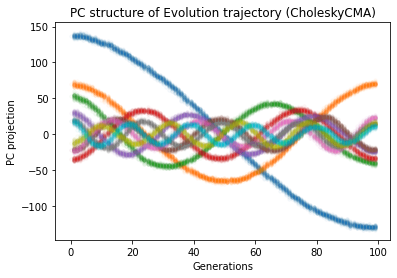

In [18]:
plt.figure()
for i in range(10):
    plt.scatter(Exp.generations, codes_proj[:, i], s=12,
                label="PC%d"%i, alpha=0.03)
plt.title("PC structure of Evolution trajectory (CholeskyCMA)")
plt.ylabel("PC projection")
plt.xlabel("Generations")
plt.show()

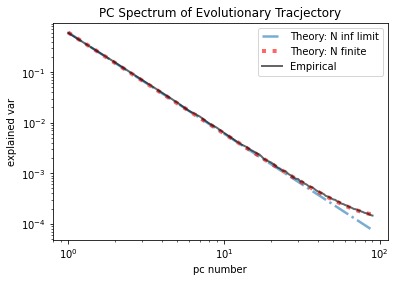

In [19]:
pca_avg = PCA(n_components=90).fit(avg_codes)
avg_codes_proj = pca_avg.transform(avg_codes)

xticks = np.arange(90)+1
theory_inf = 6/xticks**2/np.pi**2
theory_fin = 1 / (1 - np.cos(np.pi * xticks / 100)) / ((100**2 - 1) / 3)

plt.loglog(xticks, theory_inf,
           lw=2.5, ls="-.", alpha=0.6, label="Theory: N inf limit")
plt.loglog(xticks, theory_fin,
           lw=4, ls=":", color="r", alpha=0.6, label="Theory: N finite")
plt.loglog(xticks, pca_avg.explained_variance_ratio_, 
           label="Empirical", color="k", lw=2, alpha=0.6)
plt.ylabel("explained var")
plt.xlabel("pc number")
plt.title("PC Spectrum of Evolutionary Tracjectory")
plt.legend()
plt.show()

## Our New Spherical Optimizer 

Finally let's try out our newly developed spherical optimizer **SphereCMA**.

*Note, we need to use the init population created by the optimizer, the default starts at original which didn't suits spherical evolution.*

In [20]:
optim2 = ZOHA_Sphere_lr_euclid(4096, population_size=40, select_size=20, lr=1.5, sphere_norm=300)
optim2.lr_schedule(n_gen=75, mode="exp", lim=(50, 7.33) ,)
# explabel, model_unit = "alexnet_fc8_1", ("alexnet", ".classifier.Linear6", 1)
explabel, model_unit = "vit_b_16_exp", ("vit_b_16", ".heads.Linearhead", 1)
Exp2 = ExperimentEvolution(model_unit, savedir=tmpsavedir, explabel=explabel, optimizer=optim2)
# run evolutions
Exp2.run(init_code=optim2.get_init_pop()) 
# note we need to use the init population created by the optimizer, the default starts at original which didn't suits spherical evolution. 

Gen -1 max score 1.739, mean -0.150, std 0.684
 
First generation
Current Exploration 50.0 deg
synth img scores: mean -0.150 +- std 0.684
step 0  time: total 0.60s | GAN visualize 0.08s   CNN score 0.50s   optimizer step 0.01s
Gen 0 max score 1.816, mean 0.093, std 0.682
 
Step size 0.507, multip learning rate 0.761, 
New basis ang to last samples mean 0.923(0.090), min 0.507
Current Exploration 48.7 deg
synth img scores: mean 0.093 +- std 0.682
step 1  time: total 0.77s | GAN visualize 0.06s   CNN score 0.70s   optimizer step 0.01s
Gen 1 max score 6.811, mean 0.218, std 1.382
 
Step size 0.492, multip learning rate 0.738, 
New basis ang to last samples mean 0.900(0.090), min 0.492
Current Exploration 47.5 deg
synth img scores: mean 0.218 +- std 1.382
step 2  time: total 0.76s | GAN visualize 0.06s   CNN score 0.70s   optimizer step 0.01s
Gen 2 max score 7.142, mean 1.033, std 1.477
 
Step size 0.477, multip learning rate 0.715, 
New basis ang to last samples mean 0.880(0.088), min 0.4

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x432 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y basic_2.mp4


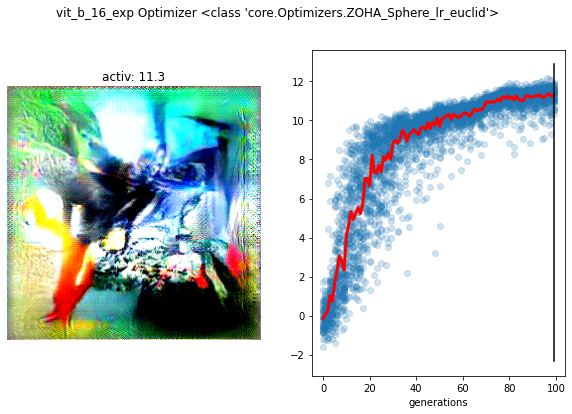

In [22]:
anim, _ = animate_evol_exp(Exp2)
anim.save('basic_2.mp4')

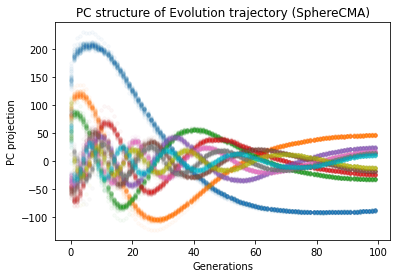

In [ ]:
codes_proj2 = PCA(n_components=50).fit_transform(Exp2.codes_all)
plt.figure()
for i in range(10):
    plt.scatter(Exp2.generations, codes_proj2[:, i], s=12, 
                label="PC%d"%i, alpha=0.03)
plt.title("PC structure of Evolution trajectory (SphereCMA)")
plt.ylabel("PC projection")
plt.xlabel("Generations")
plt.show()